In [140]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
import tf2onnx

In [297]:
COLOR = 'white'
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

In [72]:
(train_images, train_labels), (test_images, test_labels)=mnist.load_data()
x_labels=test_labels

In [73]:
train_images=train_images.reshape((60000,28,28,1))

In [74]:
train_images=train_images.astype('float32')

In [75]:
train_images/=255

In [76]:
test_images=test_images.reshape((10000,28,28,1))
test_images=test_images.astype('float32')/255

In [77]:
from tensorflow.keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

In [78]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [79]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [80]:
model.fit(train_images, 
          train_labels, 
          epochs=5,
          batch_size=64)

Epoch 1/5
938/938 [==============================] - 8s 8ms/step - loss: 0.1726 - accuracy: 0.9464
Epoch 2/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0452 - accuracy: 0.9857
Epoch 3/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0318 - accuracy: 0.9900
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0247 - accuracy: 0.9921
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0182 - accuracy: 0.9944


In [141]:
model.save('mnist')

!python -m tf2onnx.convert --saved-model mnist --output model_mnist.onnx

INFO:tensorflow:Assets written to: mnist\assets


INFO:tensorflow:Assets written to: mnist\assets
C:\Users\adamz\miniconda3\lib\runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-08-16 02:17:25,378 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-08-16 02:17:25,803 - INFO - Signatures found in model: [serving_default].
2022-08-16 02:17:25,803 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-08-16 02:17:25,806 - INFO - Output names: ['dense_3']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-08-16 02:17:25,915 - WARNING - From C:\Users\adamz\miniconda3\lib\site-packages\tf2onnx\tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_ut

In [82]:
import pathlib

model_file=pathlib.Path("mnist/")/"saved_model.pb"
#model_file.mkdir(exist_ok=True, parents=True)
m1=model_file.stat().st_size

In [83]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0245 - accuracy: 0.9928


[0.024545516818761826, 0.9927999973297119]

In [1]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_quant_model = converter.convert()

NameError: name 'tf' is not defined

In [85]:
import pathlib

tflite_models_dir = pathlib.Path("mnist_tflite_models_org/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [86]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant_org.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)
tflite_model_quant_file.stat().st_size

102272

In [87]:
#Kwantyzacja zakresu dynamicznego

In [88]:
converter = tf.lite.TFLiteConverter.from_saved_model('mnist')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [89]:
import pathlib

tflite_models_dir = pathlib.Path("mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [90]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)
m2=tflite_model_quant_file.stat().st_size

In [91]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = np.zeros((len(test_images[0]),), dtype=int)

In [92]:
interpreter.set_tensor(input_details["index"], [test_images[1]])
interpreter.invoke()
output = interpreter.get_tensor(output_details["index"])[0]
predictions = output.argmax()

In [93]:
predictions

2

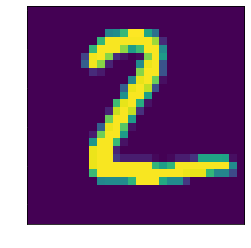

In [94]:
plt.imshow(test_images[1])

In [99]:
import time

t1=[]
pred=[]
for i in test_images:
    i=np.array([i])
    s=time.time()
    pred+=[model.predict(i).argmax()]
    e=time.time()
    t1+=[e-s]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


In [44]:
tak1=0
nie1=0
for i in range(len(pred)):
    if pred[i]==test_labels[i].argmax():
        tak1+=1
    else:
        nie1+=1

In [38]:
predictions = []
t2 = []
for i in test_images:
    interpreter.set_tensor(input_details["index"], np.array([i]))
    s=time.time()
    interpreter.invoke()
    e=time.time()
    t2+=[e-s]
    output = interpreter.get_tensor(output_details["index"])[0]
    predictions += [output.argmax()]

In [39]:
tak2=0
nie2=0
for i in range(len(predictions)):
    if predictions[i]==test_labels[i].argmax():
        tak2+=1
    else:
        nie2+=1

In [45]:
tak2/(tak2+nie2)

0.9897

In [100]:
max(t1)

0.09061264991760254

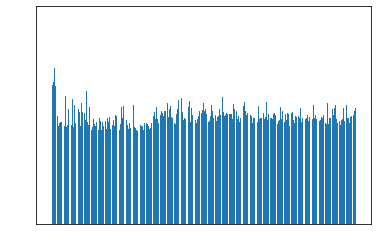

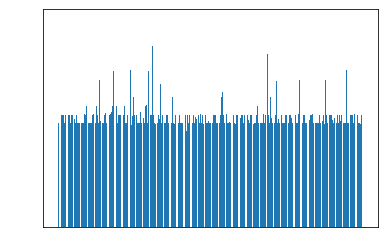

In [101]:
plt.bar(range(1,len(t1)+1),t1)
plt.show()
plt.bar(range(1,len(t2)+1),t2)
plt.show()

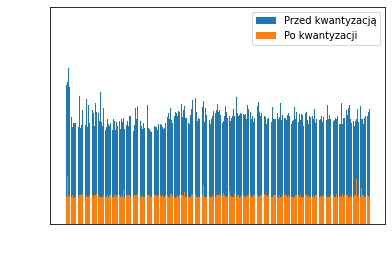

In [298]:
plt.bar(range(1,len(t1)+1),t1)
plt.bar(range(1,len(t2)+1),t2)
plt.xlabel("Numery próbek")
plt.ylabel("Czas w [s]")
plt.legend(["Przed kwantyzacją","Po kwantyzacji"])

In [103]:
#Kwantyzacja float16

In [104]:
converter = tf.lite.TFLiteConverter.from_saved_model('mnist')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

In [105]:
import pathlib

tflite_models_dir = pathlib.Path("mnist_tflite_models_float16/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [106]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant_float16.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)
m3=tflite_model_quant_file.stat().st_size

In [107]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = np.zeros((len(test_images[0]),), dtype=int)

In [108]:
interpreter.set_tensor(input_details["index"], [test_images[1]])
interpreter.invoke()
output = interpreter.get_tensor(output_details["index"])[0]
predictions = output.argmax()

In [109]:
predictions

2

In [163]:
predictions = []
t3 = []
for i in test_images:
    interpreter.set_tensor(input_details["index"], np.array([i]))
    s=time.time()
    interpreter.invoke()
    e=time.time()
    t3+=[e-s]
    output = interpreter.get_tensor(output_details["index"])[0]
    predictions += [output.argmax()]

In [164]:
tak3=0
nie3=0
for i in range(len(predictions)):
    if predictions[i]==test_labels[i].argmax():
        tak3+=1
    else:
        nie3+=1

In [165]:
tak3/(tak3+nie3)

0.993

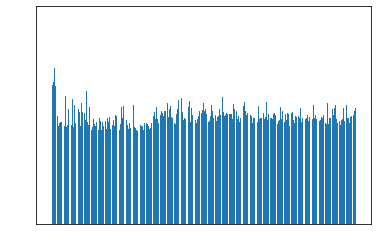

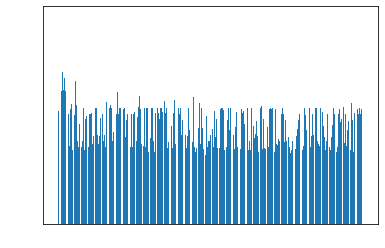

In [166]:
plt.bar(range(1,len(t1)+1),t1)
plt.show()
plt.bar(range(1,len(t2)+1),t3)
plt.show()

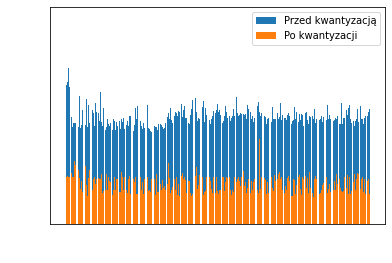

In [299]:
plt.bar(range(1,len(t1)+1),t1)
plt.bar(range(1,len(t2)+1),t3)
plt.xlabel("Numery próbek")
plt.ylabel("Czas w [s]")
plt.legend(["Przed kwantyzacją","Po kwantyzacji"])

In [115]:
#Kwantyzacja z aktywacjami int16

In [116]:
converter = tf.lite.TFLiteConverter.from_saved_model('mnist')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
tflite_quant_model = converter.convert()

In [117]:
import pathlib

tflite_models_dir = pathlib.Path("mnist_tflite_models_int16x8/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [118]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant_int16x8.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)
m4=tflite_model_quant_file.stat().st_size

In [119]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = np.zeros((len(test_images[0]),), dtype=int)

In [120]:
interpreter.set_tensor(input_details["index"], [test_images[1]])
interpreter.invoke()
output = interpreter.get_tensor(output_details["index"])[0]
predictions = output.argmax()

In [121]:
predictions = []
t4 = []
for i in test_images:
    interpreter.set_tensor(input_details["index"], np.array([i]))
    s=time.time()
    interpreter.invoke()
    e=time.time()
    t4+=[e-s]
    output = interpreter.get_tensor(output_details["index"])[0]
    predictions += [output.argmax()]

In [122]:
tak4=0
nie4=0
for i in range(len(predictions)):
    if predictions[i]==test_labels[i].argmax():
        tak4+=1
    else:
        nie4+=1

In [123]:
tak4/(tak4+nie4)

0.9929

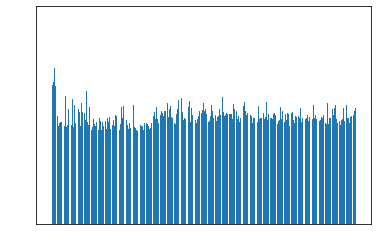

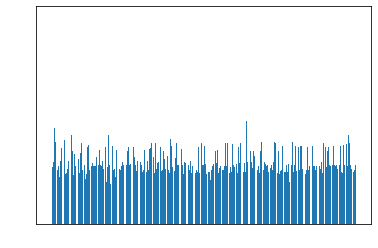

In [124]:
plt.bar(range(1,len(t1)+1),t1)
plt.show()
plt.bar(range(1,len(t2)+1),t4)
plt.show()

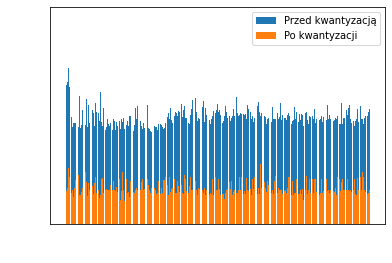

In [300]:
plt.bar(range(1,len(t1)+1),t1)
plt.bar(range(1,len(t2)+1),t4)
plt.xlabel("Numery próbek")
plt.ylabel("Czas w [s]")
plt.legend(["Przed kwantyzacją","Po kwantyzacji"])

In [126]:
#Kwantyzacja liczb całkowitych po treningu

In [276]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\adamz\AppData\Local\Temp\tmpl69dx4nb\assets


INFO:tensorflow:Assets written to: C:\Users\adamz\AppData\Local\Temp\tmpl69dx4nb\assets
C:\Users\adamz\miniconda3\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [277]:
import pathlib

tflite_models_dir = pathlib.Path("mnist_tflite_models_calkowite/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [278]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant_calkowite.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)
m5=tflite_model_quant_file.stat().st_size

In [130]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = np.zeros((len(test_images[0]),), dtype=int)

In [131]:
interpreter.set_tensor(input_details["index"], [test_images[1]])
interpreter.invoke()
output = interpreter.get_tensor(output_details["index"])[0]
predictions = output.argmax()

In [132]:
predictions = []
t5 = []
for i in test_images:
    interpreter.set_tensor(input_details["index"], np.array([i]))
    s=time.time()
    interpreter.invoke()
    e=time.time()
    t5+=[e-s]
    output = interpreter.get_tensor(output_details["index"])[0]
    predictions += [output.argmax()]

In [133]:
tak5=0
nie5=0
for i in range(len(predictions)):
    if predictions[i]==test_labels[i].argmax():
        tak5+=1
    else:
        nie5+=1

In [134]:
tak5/(tak5+nie5)

0.993

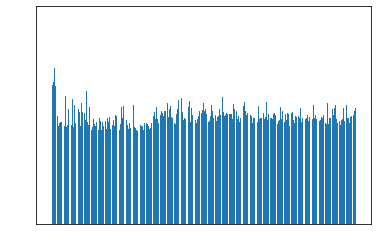

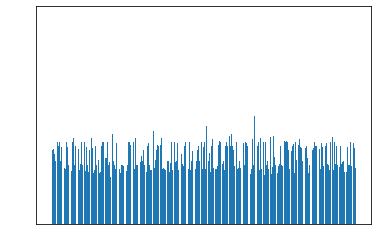

In [135]:
plt.bar(range(1,len(t1)+1),t1)
plt.show()
plt.bar(range(1,len(t2)+1),t5)
plt.show()

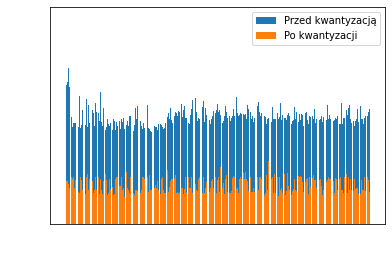

In [301]:
plt.bar(range(1,len(t1)+1),t1)
plt.bar(range(1,len(t2)+1),t5)
plt.xlabel("Numery próbek")
plt.ylabel("Czas w [s]")
plt.legend(["Przed kwantyzacją","Po kwantyzacji"])

In [279]:
#ONNX

In [281]:
import onnx

onnx_model = onnx.load("model_mnist.onnx")
onnx.checker.check_model(onnx_model)
import onnxruntime as ort
import numpy as np

ort_session = ort.InferenceSession("model_mnist.onnx")


DecodeError: Protobuf decoding consumed too few bytes: 3 out of 102736

In [282]:
import pathlib

tflite_models_dir = pathlib.Path("")
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_mnist.onnx"
tflite_model_quant_file.write_bytes(tflite_quant_model)
m6=tflite_model_quant_file.stat().st_size

In [283]:
predictions = []
t6=[]
for i in test_images:
    ort_inputs = {ort_session.get_inputs()[0].name: np.array([i])}
    s=time.time()
    output=ort_session.run(None, ort_inputs)
    e=time.time()
    t6+=[e-s]
    predictions += [np.array(output).argmax()]

In [284]:
tak6=0
nie6=0
for i in range(len(predictions)):
    if predictions[i]==test_labels[i].argmax():
        tak6+=1
    else:
        nie6+=1

In [285]:
tak6/(tak6+nie6)

0.9928

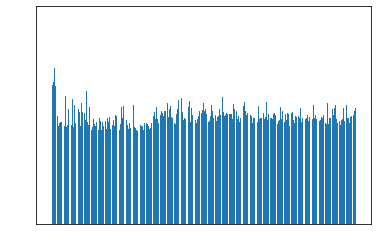

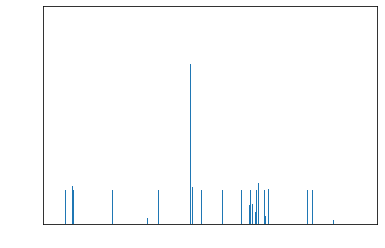

In [286]:
plt.bar(range(1,len(t1)+1),t1)
plt.show()
plt.bar(range(1,len(t2)+1),t6)
plt.show()

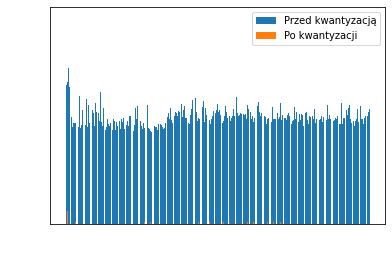

In [302]:
plt.bar(range(1,len(t1)+1),t1)
plt.bar(range(1,len(t2)+1),t6)
plt.xlabel("Numery próbek")
plt.ylabel("Czas w [s]")
plt.legend(["Przed kwantyzacją","Po kwantyzacji"])

In [288]:
std=[np.std(t1),np.std(t2),np.std(t3),np.std(t4),np.std(t5),np.std(t6)]

print(np.std(t1))
print(np.std(t2))
print(np.std(t3))
print(np.std(t4))
print(np.std(t5))
print(np.std(t6))

0.004144829065294873
0.0010199482339313705
0.003453166851570481
0.002871493752086627
0.0033535897951597967
0.0006150967755043634


In [289]:
mean=[np.mean(t1),np.mean(t2),np.mean(t3),np.mean(t4),np.mean(t5),np.mean(t6)]

print(np.mean(t1))
print(np.mean(t2))
print(np.mean(t3))
print(np.mean(t4))
print(np.mean(t5))
print(np.mean(t6))

0.04698467919826507
0.01268599510192871
0.017639288234710695
0.015877177381515502
0.017432058525085448
0.00012792222499847413


In [290]:
median=[np.median(t1),np.median(t2),np.median(t3),np.median(t4),np.median(t5),np.median(t6)]

print(np.median(t1))
print(np.median(t2))
print(np.median(t3))
print(np.median(t4))
print(np.median(t5))
print(np.median(t6))

0.04627108573913574
0.012740850448608398
0.01782965660095215
0.014963626861572266
0.01705455780029297
0.0


In [291]:
var=[np.var(t1),np.var(t2),np.var(t3),np.var(t4),np.var(t5),np.var(t6)]

print(np.var(t1))
print(np.var(t2))
print(np.var(t3))
print(np.var(t4))
print(np.var(t5))
print(np.var(t6))

1.7179607980513173e-05
1.0402943998997217e-06
1.192436130478519e-05
8.245476368272536e-06
1.1246564514199928e-05
3.783440432358652e-07


In [292]:
accuracy=[tak1/(tak1+nie1),tak2/(tak2+nie2),tak3/(tak3+nie3),tak4/(tak4+nie4),tak5/(tak5+nie5),tak6/(tak6+nie6)]

print(tak1/(tak1+nie1))
print("Dynamiczny",tak2/(tak2+nie2))
print("Float16",tak3/(tak3+nie3))
print("Int16",tak4/(tak4+nie4))
print("Pełna",tak5/(tak5+nie5))
print("ONNX",tak6/(tak6+nie6))

0.9897
Dynamiczny 0.9897
Float16 0.993
Int16 0.9929
Pełna 0.993
ONNX 0.9928


In [293]:
sr2=[]
sr3=[]
sr4=[]
sr5=[]
sr6=[]
for i in range(len(t1)):
    sr2+=[t1[i]/t2[i]]
    sr3+=[t1[i]/t3[i]]
    sr4+=[t1[i]/t4[i]]
    sr5+=[t1[i]/t5[i]]
    sr6+=[t1[i]/max(t6)]

In [294]:
sr=[np.mean(sr2),np.mean(sr3),np.mean(sr4),np.mean(sr5),np.mean(sr6)]

print(np.mean(sr2))
print(np.mean(sr3))
print(np.mean(sr4))
print(np.mean(sr5))
print(np.mean(sr6))

3.7228754767842287
2.7605458716252858
3.046172469669518
2.7924923006977678
7.594436313538093


In [295]:
print(m1//1024)
print(m2//1024)
print(m3//1024)
print(m4//1024)
print(m5//1024)
print(m6//1024)

139
99
187
99
100
100


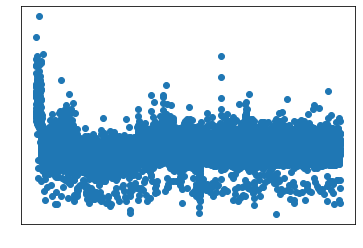

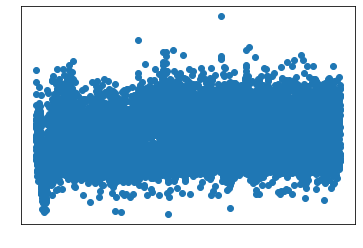

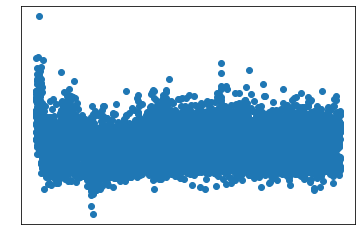

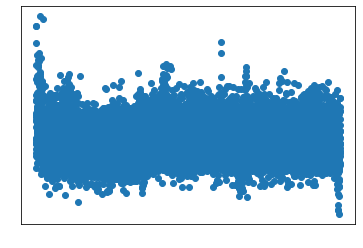

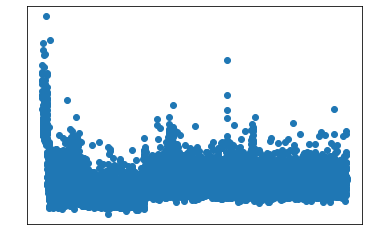

In [296]:
plt.scatter(range(1,len(t1)+1),sr2)
plt.show()
plt.scatter(range(1,len(t1)+1),sr3)
plt.show()
plt.scatter(range(1,len(t1)+1),sr4)
plt.show()
plt.scatter(range(1,len(t1)+1),sr5)
plt.show()
plt.scatter(range(1,len(t1)+1),sr6)
plt.show()

<BarContainer object of 2 artists>

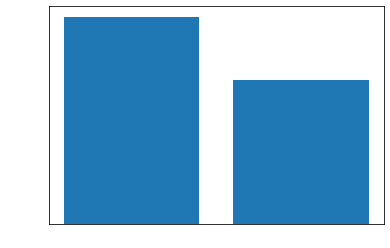

In [209]:
plt.bar(["Przed kwantyzacją","Po kwantyzacji"],std[0:5:3])

<BarContainer object of 2 artists>

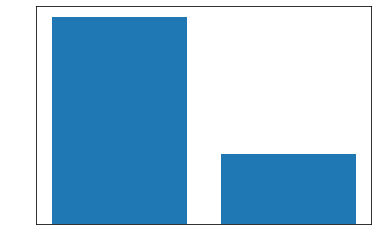

In [210]:
plt.bar(["Przed kwantyzacją","Po kwantyzacji"],mean[0:5:3])

<BarContainer object of 2 artists>

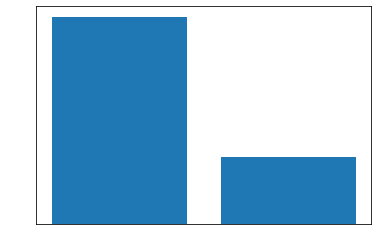

In [211]:
plt.bar(["Przed kwantyzacją","Po kwantyzacji"],median[0:5:3])

<BarContainer object of 2 artists>

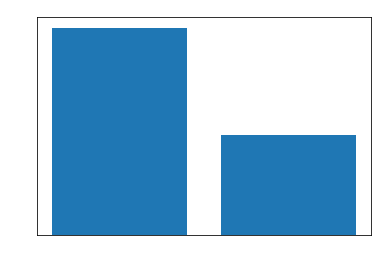

In [212]:
plt.bar(["Przed kwantyzacją","Po kwantyzacji"],var[0:5:3])

In [213]:
l=[1,2,3,4,5]
print(l[0:6:4])

[1, 5]


<BarContainer object of 4 artists>

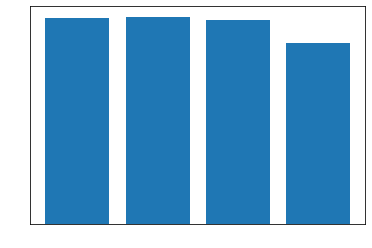

In [222]:
plt.bar(["Dynamiczny","Float16","Int16","Pełna"],sr)